# Quality Complaints Classification

ML model to classify whether a quality complaint is valid or not.

In [1]:
import warnings
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from dython.nominal import associations
from sklearn.model_selection import train_test_split

from helpers import constants

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
cmap = plt.get_cmap('viridis')

In [23]:
# Pretty print
colors = {'PURPLE':'\033[95m', 'CYAN':'\033[96m', 'DARKCYAN':'\033[36m', 'BLUE':'\033[94m',
          'GREEN':'\033[92m', 'YELLOW':'\033[93m', 'RED':'\033[91m','BOLD':'\033[1m',
          'UNDERLINE':'\033[4m', 'END':'\033[0m'}

## EDA

1. Converting the variables to categorical
2. Drop NA values
3. Summary statistics
4. Histograms
5. Statistical tests
6. Association matrix

In [3]:
df = pd.read_csv('db/dataset-qc.csv', sep=';', usecols=constants.COLUMNS)

In [4]:
df.head()

,brand,hybrid,batch,sieve,treatment,reason,result,quantity,city,state,germination
0,0,0,0,0,0,insect attack,not proceed,20.0,0,MG,98.0
1,0,1,1,1,1,insect attack,not proceed,3.0,1,MS,99.0
2,0,1,2,1,2,insect attack,not proceed,27.0,1,MS,99.0
3,0,2,3,2,2,insect attack,not proceed,382.0,2,MT,99.0
4,0,3,4,3,2,insect attack,not proceed,100.0,2,MT,99.0


In [5]:
for cat_col in constants.CATEGORICAL_COLUMNS:
    df[cat_col] = df[cat_col].astype('category')
df['result'] = df['result'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   brand        2584 non-null   category
 1   hybrid       2584 non-null   category
 2   batch        2584 non-null   category
 3   sieve        2584 non-null   category
 4   treatment    2584 non-null   category
 5   reason       2584 non-null   category
 6   result       2584 non-null   category
 7   quantity     2547 non-null   float64 
 8   city         2584 non-null   category
 9   state        2515 non-null   category
 10  germination  2097 non-null   float64 
dtypes: category(9), float64(2)
memory usage: 175.6 KB


In [7]:
df.dropna(inplace=True)
df.describe()

,quantity,germination
count,2035.000000,2035.000000
mean,98.840295,97.148403
std,156.241680,2.020687
min,0.000000,82.000000
25%,20.000000,96.000000
50%,45.000000,98.000000
75%,108.000000,99.000000
max,1400.000000,100.000000


In [8]:
counts = df["result"].value_counts()

fig1 = px.bar(
    x=counts.index,
    y=counts.values,
    color=counts.values,
    color_continuous_scale="viridis",
    labels={"x": "Result", "y": "Count"},
    title="Histogram of Results",
)

fig1.update_traces(text=counts.values, textposition="outside")
fig1.update_yaxes(range=[0, max(counts.values) * 1.1])
fig1.update_layout(bargap=0.5, width=600, height=400, coloraxis_showscale=False)

fig1.show()

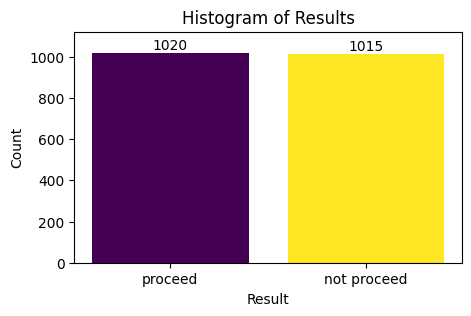

In [9]:
plt.figure(figsize=(5, 3))
colors = cmap(np.linspace(0, 1, len(counts)))

bars = plt.bar(counts.index, counts.values, color=colors)

plt.xlabel("Result")
plt.ylabel("Count")
plt.title("Histogram of Results")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha="center", va="bottom")
plt.ylim(0, max(counts.values) * 1.1)
plt.show()

In [10]:
counts = df["reason"].value_counts()

fig2 = px.bar(
        x=counts.index[:3],
        y=counts.values[:3],
        text=counts.values[:3],
        color=counts.values[:3],
        color_continuous_scale="viridis",
        labels={"x": "Reason", "y": "Count"},
        title="Top 3 reasons for all complaints",
    )

fig2.update_traces(text=counts.values, textposition="outside")
fig2.update_yaxes(range=[0, max(counts.values) * 1.1])
fig2.update_layout(bargap=0.5, width=600, height=400, coloraxis_showscale=False)
fig2.show()

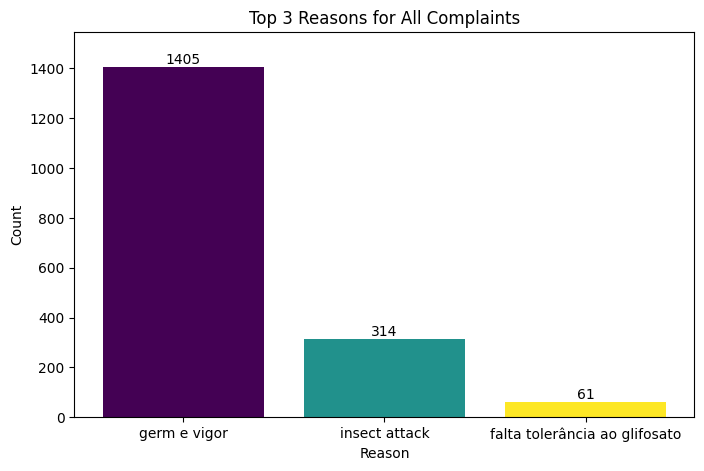

In [11]:
plt.figure(figsize=(8, 5))
colors = cmap(np.linspace(0, 1, 3))
bars = plt.bar(counts.index[:3], counts.values[:3], color=colors)
plt.xlabel('Reason')
plt.ylabel('Count')
plt.title('Top 3 Reasons for All Complaints')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')
    
plt.ylim(0, max(counts.values[:3]) * 1.1)

plt.show()

In [13]:
bar1 = go.Bar(
    name="proceed",
    x=df[df["result"] == "proceed"]["reason"].value_counts().index[:1],
    y=df[df["result"] == "proceed"]["reason"].value_counts().values[:1],
    text=df[df["result"] == "proceed"]["reason"].value_counts().values[:1],
    textposition="auto",
    marker_color="#440154",
)

bar2 = go.Bar(
    name="not proceed",
    x=df[df["result"] == "not proceed"]["reason"].value_counts().index[:1],
    y=df[df["result"] == "not proceed"]["reason"].value_counts().values[:1],
    text=df[df["result"] == "not proceed"]["reason"].value_counts().values[:1],
    textposition="auto",
    marker_color="#31688e"
)

fig3 = go.Figure(data=[bar1, bar2])

fig3.update_layout(
    barmode="group",
    title_text="Top reason for complaints by result",
    bargap=0.5,
    width=600,
    height=400,
)

fig3.show()

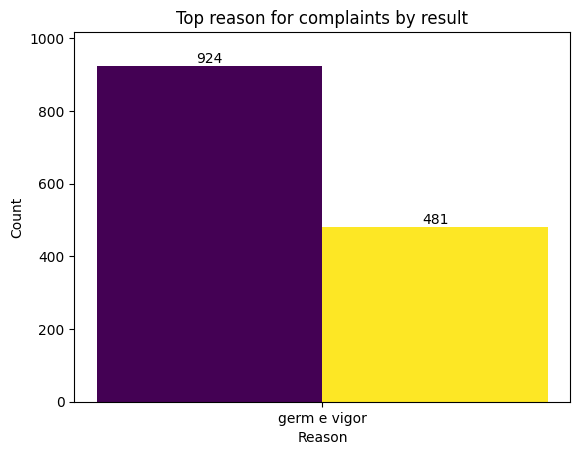

In [14]:
colors = cmap(np.linspace(0, 1, 2))

x1 = np.arange(1)  # x1 is now an array of indices
y1 = df[df["result"] == "proceed"]["reason"].value_counts().values[:1]
bars1 = plt.bar(x1, y1, color=colors[0], align='edge', width=-0.4)

x2 = np.arange(1)  # x2 is now an array of indices
y2 = df[df["result"] == "not proceed"]["reason"].value_counts().values[:1]
bars2 = plt.bar(x2, y2, color=colors[1], align='edge', width=0.4)

plt.xlabel('Reason')
plt.ylabel('Count')
plt.title('Top reason for complaints by result')

plt.xticks(x1, df[df["result"] == "proceed"]["reason"].value_counts().index[:1])

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')


plt.ylim(0, max(y1) * 1.1)

plt.show()

## Statistical tests
### Chi-Squared Test

The Chi-Squared Test of Independence is used to determine if there is a significant association between two categorical variables. The null hypothesis (H0) is that the variables are independent, and the alternative hypothesis (H1) is that the variables are dependent.

The formula is:
$$\chi^2 = \sum \frac {(O - E)^2}{E}$$

Where $O$ is the observed frequency and $E$ is the expected frequency.

In [33]:
categorical_variables = constants.CATEGORICAL_COLUMNS
alpha = 0.05

for var in categorical_variables:
    contingency_table = pd.crosstab(df["result"], df[var])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print('Chi-Squared Test of Independence for variable -> ' + colors['UNDERLINE'] + var + colors['END'])
    print(colors['BOLD'] + 'p-value' + colors['END'] + ' = ' + str(p))
    if p <= alpha:
        print(colors['GREEN'] +"Dependent (reject H0)\n" + colors['END'])
    else:
        print(colors['RED'] +"Independent (H0 holds true)\n" + colors['END'])

Chi-Squared Test of Independence for variable -> brand
p-value = 0.03667715437337973
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> hybrid
p-value = 3.109578593075626e-57
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> batch
p-value = 3.451450305546585e-24
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> sieve
p-value = 9.997082859099603e-11
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> treatment
p-value = 1.3373529880764348e-56
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> reason
p-value = 7.841081619175655e-108
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> city
p-value = 9.951875729527798e-26
Dependent (reject H0)

Chi-Squared Test of Independence for variable -> state
p-value = 2.69155224489678e-14
Dependent (reject H0)



### Cramer's V
Cramer's V is a scaled version of the chi-squared test statistic $\chi^2$, which ranges from 0 to 1. It is used to measure the strength of association between two nominal variables. The value of Cramer's V ranges from 0 to 1, where 0 indicates no association between the variables, and 1 indicates a strong association between the variables.

The formula is:
$$Cramer's V = \sqrt{\chi^2/(n\cdot(k-1))}$$

Where $\chi^2$ is the chi-squared test statistic, $n$ is the number of observations, and $k$ is the number of categories in the contingency table.

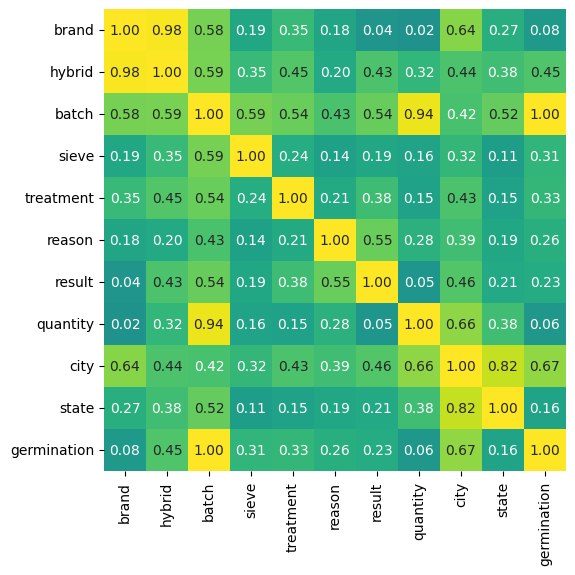

In [34]:
cramers_v = associations(df, figsize=(6, 6), cbar=False, cmap="viridis")

In [48]:
df_associations = pd.DataFrame(cramers_v["corr"])
sorted_associations = pd.DataFrame(
    df_associations["result"].sort_values(ascending=False)[1:]
)

fig4 = px.bar(
    sorted_associations,
    y="result",
    x=sorted_associations.index,
    color="result",
    color_continuous_scale="viridis",
    title="Ranked Associations with Result Variable",
)

fig4.update_yaxes(range=[0, max(sorted_associations["result"]) * 1.1])
fig4.update_traces(text=round(sorted_associations["result"], 3), textposition="outside")

fig4.show()

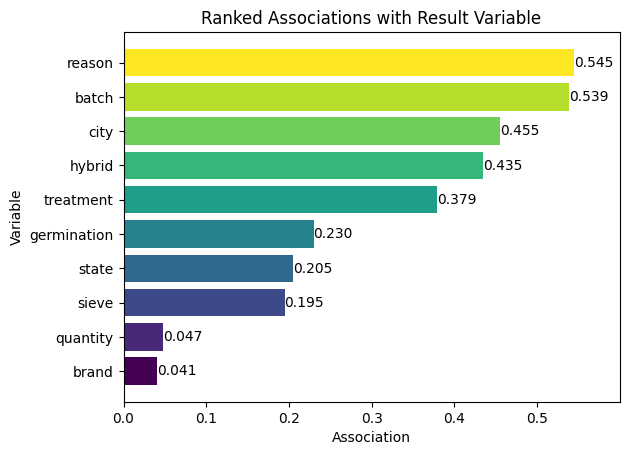

In [49]:
sorted_associations = sorted_associations.sort_values(by="result", ascending=True)

colors = cmap(np.linspace(0, 1, len(sorted_associations)))

bars = plt.barh(sorted_associations.index, sorted_associations["result"], color=colors)

plt.xlabel("Association")
plt.ylabel("Variable")
plt.title("Ranked Associations with Result Variable")

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left')
    

plt.xlim(0, max(sorted_associations["result"]) * 1.1)

plt.show()

## Model

In [ ]:
X = df.drop('result', axis=1)
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)